# CLASIFICAR ggF y VBF CON MACHINE LEARNING

## PAQUETES

In [1]:
# dataframes 
import numpy as np
import pandas as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funcion de xgboost que clasifica
from xgboost import XGBClassifier

# graficar el arbol de desiciones del modelo, rcparams es para que se vea HD
from xgboost import plot_tree
from matplotlib.pylab import rcParams

# medir que tan bueno es el modelo
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# encontrar mejor modelo (validacion)
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score

# ver la prueba de ks
from scipy.stats import kstest

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *
from machine_learning import *
from metricas import *

# para recargar los modulos mientras los voy debugeando
%load_ext autoreload
%autoreload 2

# LECTURA DE DATOS

In [2]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_ml.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [3]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:03,  2.17it/s]

samples/VBF/frvz_vbf_500757


 25%|██▌       | 2/8 [00:00<00:02,  2.15it/s]

samples/VBF/frvz_vbf_500758


 38%|███▊      | 3/8 [00:01<00:02,  2.05it/s]

samples/VBF/frvz_vbf_500759


 50%|█████     | 4/8 [00:01<00:01,  2.19it/s]

samples/VBF/frvz_vbf_500760


 62%|██████▎   | 5/8 [00:02<00:01,  2.12it/s]

samples/VBF/frvz_vbf_500761


 75%|███████▌  | 6/8 [00:02<00:00,  2.09it/s]

samples/VBF/frvz_vbf_500762


 88%|████████▊ | 7/8 [00:03<00:00,  2.14it/s]

samples/VBF/frvz_vbf_500763


100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


samples/VBF/frvz_vbf_500764


100%|██████████| 9/9 [00:16<00:00,  1.78s/it]


njet30          mjj      detajj   
origin df_name                                                        
VBF    samples/VBF/frvz_vbf_500757       2  1316.194214    5.130603  \
       samples/VBF/frvz_vbf_500757       7  2287.880371    7.156201   
       samples/VBF/frvz_vbf_500757       2  1568.506470    6.255918   
       samples/VBF/frvz_vbf_500757       4   471.740875    1.960242   
       samples/VBF/frvz_vbf_500757       8  1150.059692    4.557185   
...                                    ...          ...         ...   
ggF    samples/ggF/frvz_ggf_508893       1    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       3   240.689178    1.942230   
       samples/ggF/frvz_ggf_508893       2   143.422470    2.548514   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   
       samples/ggF/frvz_ggf_508893       0    -0.999000 -999.000000   

                                        dphijj         MET  scale1fb   
origin df_name                                                         
VBF    samples/VBF/frvz_vbf_500757    1.032967  177.043106  0.000486  \
       samples/VBF/frvz_vbf_500757   -2.580441  101.195091  0.000502   
       samples/VBF/frvz_vbf_500757   -1.375577  130.909744  0.000429   
       samples/VBF/frvz_vbf_500757    2.980181  491.291687  0.000531   
       samples/VBF/frvz_vbf_500757    2.197970  115.439743  0.000014   
...                                        ...         ...       ...   
ggF    samples/ggF/frvz_ggf_508893 -999.000000   40.554482  0.028479   
       samples/ggF/frvz_ggf_508893    0.768057   76.802452  0.029882   
       samples/ggF/frvz_ggf_508893    2.000947   26.644657  0.029517   
       samples/ggF/frvz_ggf_508893 -999.000000   10.709071  0.029929   
       samples/ggF/frvz_ggf_508893 -999.000000   10.808948  0.030318   

                                      intLumi        jet1_pt    jet1_eta   
origin df_name                                                             
VBF    samples/VBF/frvz_vbf_500757  44.299999  104969.406250   -3.187121  \
       samples/VBF/frvz_vbf_500757  44.299999   72039.820312    3.637084   
       samples/VBF/frvz_vbf_500757  44.299999  120273.304688   -2.382490   
       samples/VBF/frvz_vbf_500757  44.299999  178915.984375    1.259632   
       samples/VBF/frvz_vbf_500757  44.299999  189834.156250   -2.913896   
...                                       ...            ...         ...   
ggF    samples/ggF/frvz_ggf_508893  58.450001   33552.746094    0.995871   
       samples/ggF/frvz_ggf_508893  58.450001  125251.289062   -2.288580   
       samples/ggF/frvz_ggf_508893  58.450001   40318.128906   -3.305732   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   
       samples/ggF/frvz_ggf_508893  58.450001    -999.000000 -999.000000   

                                      jet1_phi        jet1_e        jet2_pt   
origin df_name                                                                
VBF    samples/VBF/frvz_vbf_500757   -0.087903  1.273288e+06   98169.875000  \
       samples/VBF/frvz_vbf_500757    0.712928  1.369027e+06   56599.265625   
       samples/VBF/frvz_vbf_500757   -2.404870  6.569827e+05   39280.699219   
       samples/VBF/frvz_vbf_500757   -2.167910  3.411552e+05  133583.312500   
       samples/VBF/frvz_vbf_500757   -1.059290  1.754382e+06   72083.078125   
...                                        ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893   -2.499207  5.242589e+04    -999.000000   
       samples/ggF/frvz_ggf_508893    1.335905  6.239932e+05   79405.820312   
       samples/ggF/frvz_ggf_508893    0.382778  5.504859e+05   36411.175781   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   
       samples/ggF/frvz_ggf_508893 -999.000000 -9.990000e+02    -999.000000   

                                      jet2_eta    jet2_phi        jet2_e  
origin df_name                                                            
VBF    s

# CORTES Y PREPROCESADO

In [4]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_ml = df_all
df_ml = df_ml.droplevel('df_name')
df_ml = df_ml.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_ml = df_ml.reset_index(level='origin')
df_ml = pd.get_dummies(df_ml, columns=['origin'], dtype=int)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml.drop(['origin_VBF', 'origin_ggF'], axis=1) 
df_y = df_ml[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 



,mjj,detajj,dphijj,MET,jet1_pt,jet1_eta,jet1_phi,jet1_e,jet2_pt,jet2_eta,jet2_phi,jet2_e,origin_VBF,origin_ggF
0,1316.194214,5.130603,1.032967,177.043106,104969.406250,-3.187121,-0.087903,1.273288e+06,98169.875000,1.943482,-1.120870,3.498132e+05,1,0
1,2287.880371,7.156201,-2.580441,101.195091,72039.820312,3.637084,0.712928,1.369027e+06,56599.265625,-3.519117,-2.989815,9.561007e+05,1,0
2,1568.506470,6.255918,-1.375577,130.909744,120273.304688,-2.382490,-2.404870,6.569827e+05,39280.699219,3.873428,-1.029293,9.452691e+05,1,0
3,471.740875,1.960242,2.980181,491.291687,178915.984375,1.259632,-2.167910,3.411552e+05,133583.312500,3.219874,1.135094,1.674184e+06,1,0
4,1150.059692,4.557185,2.197970,115.439743,189834.156250,-2.913896,-1.059290,1.754382e+06,72083.078125,1.643289,3.025926,1.938794e+05,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4628571,-0.999000,-999.000000,-999.000000,40.554482,33552.746094,0.995871,-2.499207,5.242589e+04,-999.000000,-999.000000,-999.000000,-9.990000e+02,0,1
4628572,240.689178,1.942230,0.768057,76.802452,125251.289062,-2.288580,1.335905,6.239932e+05,79405.820312,-0.346350,0.567848,8.514269e+04,0,1
4628573,143.422470,2.548514,2.000947,26.644657,40318.128906,-3.305732,0.382778,5.504859e+05,36411.175781,-0.757218,-1.618170,4.770174e+04,0,1
4628574,-0.999000,-999.000000,-999.000000,10.709071,-999.000000,-999.000000,-999.000000,-9.990000e+02,-999.000000,-999.000000,-999.000000,-9.990000e+02,0,1


# ANALISIS PREVIO

In [5]:
# veamos si hago bien el corte de njet30
# sns.histplot(data = df_all["njet30"], bins=30)
# sí se borraban cosas, habian datos originalmente con njet30 con valores 0 o 1, la cosa que me decía el número de entradas antes y después no estaba actualizado para el código actual

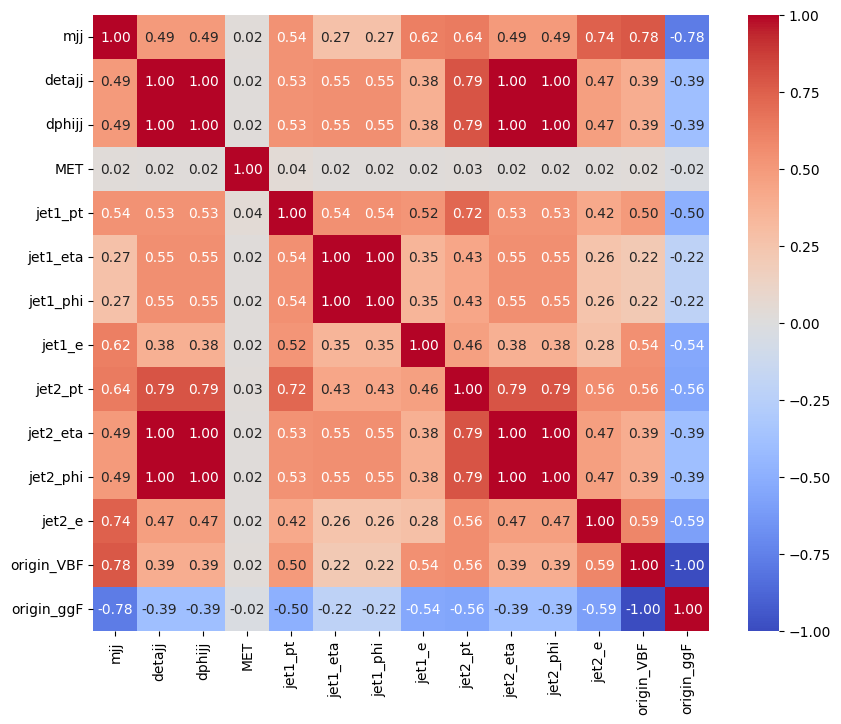

In [26]:
########################################################
##################### CORRELACION ######################
########################################################

plot_correlacion(df_ml)

In [7]:
# ver las correlaciones en orden de importancia con origin vbf
correlaciones(df_ml, "origin_VBF")

origin_VBF    1.000000
mjj           0.781128
jet2_e        0.589224
jet2_pt       0.561961
jet1_e        0.542713
jet1_pt       0.496771
detajj        0.394459
dphijj        0.392952
jet2_eta      0.392949
jet2_phi      0.392946
jet1_phi      0.215034
jet1_eta      0.215031
MET           0.024181
origin_ggF   -1.000000
Name: origin_VBF, dtype: float64

notemos que podría borrar las variables phi, y solo quedarme con las eta (o viceversa)

Ademas borro jet2_phi porque se parece mucho a dphijj

Ademas borro MET porque no aporta en nada

# PREPROCESADO MEJORADO TRAS ANALISIS

In [9]:
df_ml['origin_ggF']
df_ml2 = df_ml.drop(['jet2_eta', 'jet1_eta', 'detajj', 'jet2_phi', 'MET', 'origin_ggF'], axis=1)

# separo entre datos de entrenamiento y datos de validacion
df_X = df_ml2.drop(['origin_VBF'], axis=1) 
df_y = df_ml2[["origin_VBF"]]

# separo entre datos de entrenamiento y datos de validacion
X_train, X_metrico, y_train, y_metrico = train_test_split(df_X, df_y, test_size=0.3)#, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_metrico, y_metrico, test_size=0.5)

df_ml2

,mjj,dphijj,jet1_pt,jet1_phi,jet1_e,jet2_pt,jet2_e,origin_VBF
0,1316.194214,1.032967,104969.406250,-0.087903,1.273288e+06,98169.875000,3.498132e+05,1
1,2287.880371,-2.580441,72039.820312,0.712928,1.369027e+06,56599.265625,9.561007e+05,1
2,1568.506470,-1.375577,120273.304688,-2.404870,6.569827e+05,39280.699219,9.452691e+05,1
3,471.740875,2.980181,178915.984375,-2.167910,3.411552e+05,133583.312500,1.674184e+06,1
4,1150.059692,2.197970,189834.156250,-1.059290,1.754382e+06,72083.078125,1.938794e+05,1
...,...,...,...,...,...,...,...,...
4628571,-0.999000,-999.000000,33552.746094,-2.499207,5.242589e+04,-999.000000,-9.990000e+02,0
4628572,240.689178,0.768057,125251.289062,1.335905,6.239932e+05,79405.820312,8.514269e+04,0
4628573,143.422470,2.000947,40318.128906,0.382778,5.504859e+05,36411.175781,4.770174e+04,0
4628574,-0.999000,-999.000000,-999.000000,-999.000000,-9.990000e+02,-999.000000,-9.990000e+02,0


nota: no cambió en nada el resultado, no afectó las cosas que borré

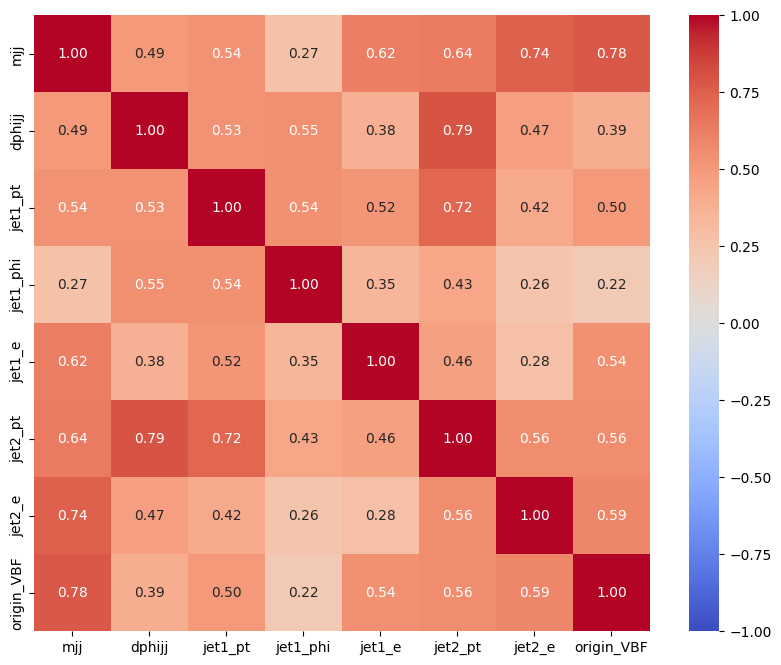

In [25]:
plot_correlacion(df_ml2)

In [11]:
correlaciones(df_ml2, "origin_VBF")

origin_VBF    1.000000
mjj           0.781128
jet2_e        0.589224
jet2_pt       0.561961
jet1_e        0.542713
jet1_pt       0.496771
dphijj        0.392952
jet1_phi      0.215034
Name: origin_VBF, dtype: float64

In [12]:
prueba_ks(df_ml2, "mjj", "norm")

Se rechaza la hipótesis nula, p vale: 0.0. Los datos no siguen una distribución norm.


# MACHINE LEARNING

In [13]:
########################################################
#################### CLASIFICACION #####################
########################################################

modelo = do_classification(X_train, y_train)

hola3


In [14]:
# grafico_decisiones(modelo)

In [15]:
precision(modelo, X_test, y_test)

Precisión del modelo: 97.55%


In [16]:
matriz = confusion(modelo, X_test, y_test)
pd.DataFrame(matriz)

,0,1
0,63976,10071
1,6954,613285


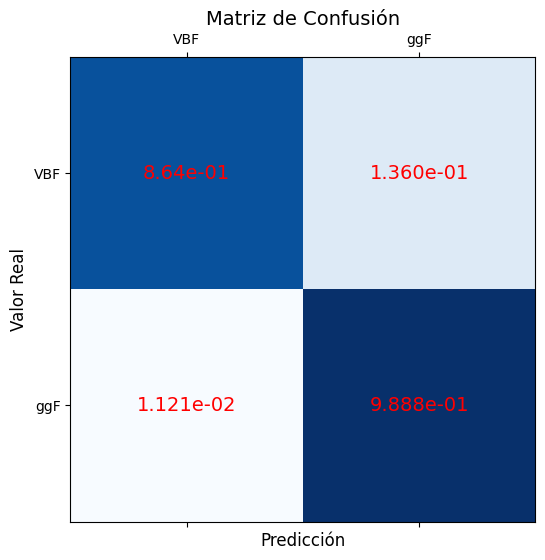

In [17]:
plot_matriz(matriz, porcentaje = True, normalizado=True)

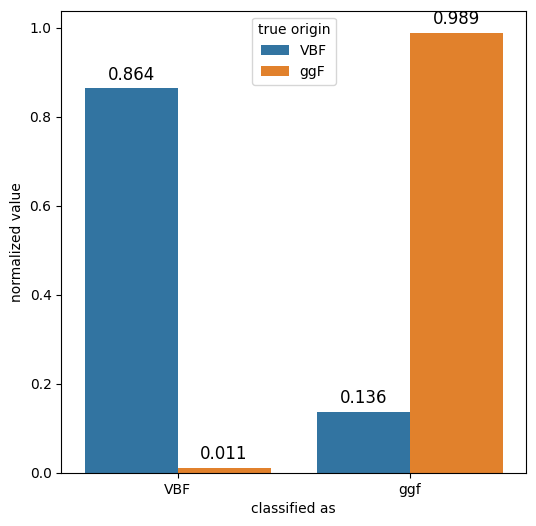

In [32]:
plot_confusion_barras(matriz)

In [19]:
# Encontrar mejor modelo
# best_model = find_best_model(X_train, y_train, X_test, y_test, X_val, y_val)

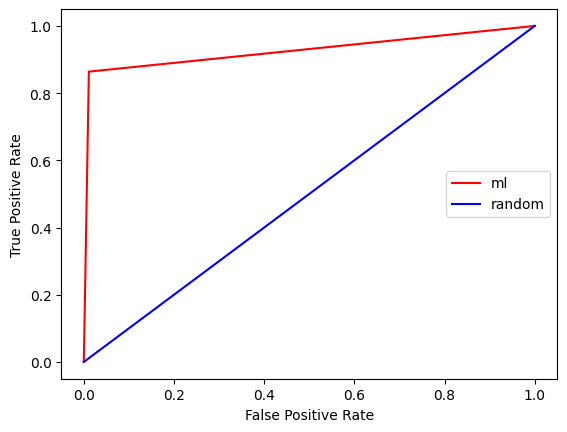

In [34]:
plot_ROC(modelo, X_test, y_test)

In [21]:
modelo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'auc'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)